In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
from circuit_extract import visualize_circuit_masks


import inference
import train

/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we

In [2]:
import importlib

importlib.reload(inference)
importlib.reload(train)

<module 'train' from '/home/cabbagepatch/Code/MI/cnn_talib/train.py'>

In [3]:
def model_config(ds_name: str, lr: float, epochs: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "epochs": epochs, 
        "lr": lr,
        # "pfrac": pfrac,
    }

def circuit_config(ds_name: str, lr: float, cepochs: int, k_w: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "cepochs": cepochs, 
        "lr": lr,
        "k_w": k_w,
    }
    

### Train Sparse Model ###

In [4]:
print("\n--- Phase 1: Initialize Model ---")
inp_shape = (1, 28, 28)
model = inference.CNN(nc=1, nf=16, num_classes=10, inp_shape=inp_shape)


--- Phase 1: Initialize Model ---


In [6]:
print("\n--- Phase 2: Train Sparse Baseline ---")
def scheduler(start, end, start_sparsity, target_sparsity, alpha):
    def f(epochs):
        t = min(max(0, epochs-start), end-start)/ (end-start)
        t = t**alpha
        return (target_sparsity* t + (1-t) * start_sparsity)
    return f

sched = scheduler(3, 12, 1, 0.05, 0.5)
# sched(0)
# for epoch in range(1,12):
#     print(sched(epoch+1))

cfg = model_config(ds_name='mnist', lr=1e-3, epochs=12)
device = cfg['device']
print(f"Running on {device}")

train.train_model(
    model=model,
    lr=cfg['lr'],
    b1=0.9, b2=0.999,
    # pfrac=cfg['pfrac'],
    scheduler = sched, 
    ds_name="mnist-baseline",
    eps=1e-8,
    epochs=cfg['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
Running on cpu


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


n_params 20490 n_params_wd 20432
Epoch 0 | Train Acc: 0.9788 | Test Acc: 0.9789
Epoch 1 | Train Acc: 0.9885 | Test Acc: 0.9869
Epoch 2 | Train Acc: 0.9904 | Test Acc: 0.9863
Epoch 3 | Train Acc: 0.9929 | Test Acc: 0.9897
Epoch 4 | Train Acc: 0.9954 | Test Acc: 0.9901
Epoch 5 | Train Acc: 0.9958 | Test Acc: 0.9901
Epoch 6 | Train Acc: 0.9970 | Test Acc: 0.9908
Epoch 7 | Train Acc: 0.9974 | Test Acc: 0.9906
Epoch 8 | Train Acc: 0.9957 | Test Acc: 0.9873
Epoch 9 | Train Acc: 0.9897 | Test Acc: 0.9839
Epoch 10 | Train Acc: 0.9813 | Test Acc: 0.9765
Epoch 11 | Train Acc: 0.9294 | Test Acc: 0.9313


In [92]:
non_zero = sum([(p != 0).sum() for p in model.parameters()])
total = sum([p.numel() for p in model.parameters()])

print(f"{non_zero/total:.4f}")

# when retaining also retain other ones
# scheduler also add (50 percent of training steos then reach sparsity)
# iteratively sparsify features after starting from 0 percent sparsty
# circuits should not rely on 
# for every neuron retain some weights
# try pretraining on generation
#try on more complex datasets, cmnist, cifar10, pacs
#maybe try portability
#try training on
#try the weird loss thing
#mistake : apply sigmoid estimator
#see this as an angle to improve DG
#how to work with circuits that are not end to end // have to use bigger models
#ha405 // visual reasoning
#how to find neurons/circuits correspoding to sprurious features / circuits
#work with different circuits in cross-domain settings
#randomization makes network more generalizable
#maybe try and find work in compilers?
#LLMs ka kaam karo
#senior



0.0499


### Extracting circuit ###

In [111]:
print("\n--- Phase 3: Extract Circuit ---")

cfg = circuit_config(ds_name='mnist-circuit-2', lr=1e-3, cepochs=10, k_w=0.05)
device = cfg['device']
print(f"Running on {device}")

circuit = train.extract_circuit(
    model=model,
    lr=cfg['lr'],
    b1=0.9, b2=0.999,
    ds_name=cfg['dataset'],
    eps=1e-8,
    epochs=cfg['cepochs'],
    device=device,
    l0_lambda=cfg['k_w'],
    seed=cfg['seed'],
)


--- Phase 3: Extract Circuit ---
Running on cpu
Calculating mean activations...


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Initializing Circuit...
Extracting Circuit (L0 Lambda=0.05)...
Epoch 0 | Loss: 1619.8109 | Avg Mask: -0.136 | Total Non-Zero: 408.0 | | Circuit Acc: 0.8759
Epoch 1 | Loss: 8.3336 | Avg Mask: -0.689 | Total Non-Zero: 68.0 | | Circuit Acc: 0.8968
Epoch 2 | Loss: 3.8554 | Avg Mask: -1.016 | Total Non-Zero: 52.0 | | Circuit Acc: 0.8968
Epoch 3 | Loss: 3.5363 | Avg Mask: -1.278 | Total Non-Zero: 49.0 | | Circuit Acc: 0.8968
Epoch 4 | Loss: 3.4443 | Avg Mask: -1.463 | Total Non-Zero: 46.0 | | Circuit Acc: 0.8968
Epoch 5 | Loss: 3.3908 | Avg Mask: -1.624 | Total Non-Zero: 46.0 | | Circuit Acc: 0.8968
Epoch 6 | Loss: 3.3907 | Avg Mask: -1.774 | Total Non-Zero: 46.0 | | Circuit Acc: 0.8968
Epoch 7 | Loss: 3.3906 | Avg Mask: -1.918 | Total Non-Zero: 46.0 | | Circuit Acc: 0.8968
Epoch 8 | Loss: 3.3906 | Avg Mask: -2.058 | Total Non-Zero: 46.0 | | Circuit Acc: 0.8968
Epoch 9 | Loss: 3.3906 | Avg Mask: -2.195 | Total Non-Zero: 46.0 | | Circuit Acc: 0.8968



--- Phase 4: Visualize Results ---


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Bool

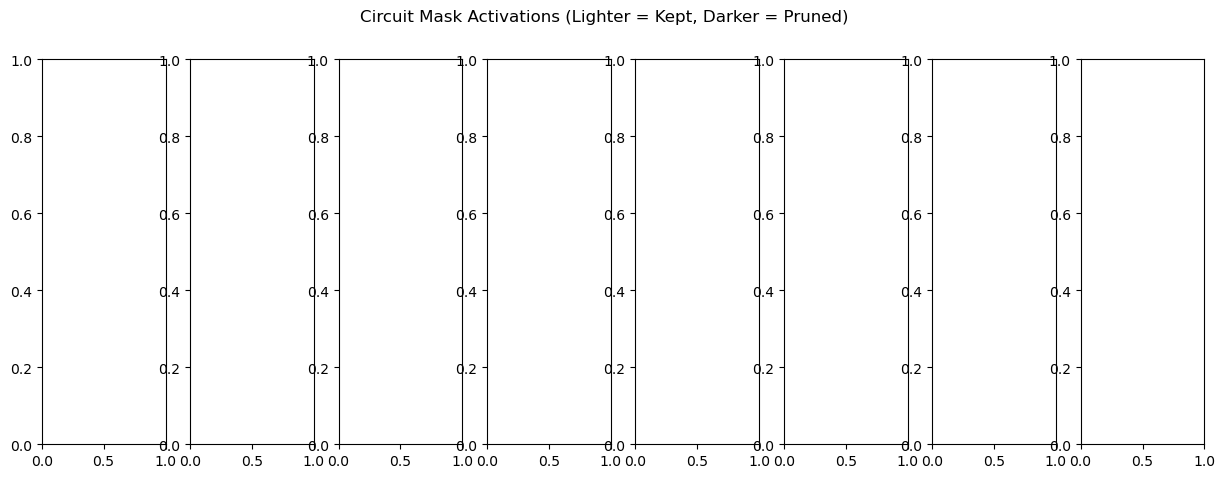

In [ ]:
# 4. Visualize
# print("\n--- Phase 4: Visualize Results ---")
# visualize_circuit_masks(circuit)

# print("\nObjective Complete: Baseline run, circuit extraction, and visualization finished.")

### Finetuned layer

In [ ]:
print("\n--- Phase 2: Train Sparse Baseline ---")
train.finetune(
    model=model,
    num_classes=2,
    lr=cfg['baseline']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['baseline']['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
n_params 23628 n_params_wd 23568


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0 | Train Acc: 0.9357 | Test Acc: 0.9456
Epoch 1 | Train Acc: 0.9511 | Test Acc: 0.9550
Epoch 2 | Train Acc: 0.9436 | Test Acc: 0.9498


In [64]:
# 3. Extract Circuit
print("\n--- Phase 3: Extract Circuit ---")
# Note: We pass the *trained* model to the circuit extractor
cfg['circuit']['l0_lambda'] = 0.0001
cfg['circuit']['lr'] = 1e-2
cfg['circuit']['epochs'] = 20
circuit = train.extract_circuit(
    model=model,
    lr=cfg['circuit']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['circuit']['epochs'],
    device=device,
    l0_lambda=cfg['circuit']['l0_lambda'],
    seed=cfg['seed']
)


--- Phase 3: Extract Circuit ---
Calculating mean activations...


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Initializing Circuit...
Extracting Circuit (L0 Lambda=0.0001)...
Epoch 0 | Loss: 4.3552 | Avg Mask: -1.278 | Total Non-Zero: 2337.0 | | Circuit Acc: 0.0434
Epoch 1 | Loss: 1.8895 | Avg Mask: -1.573 | Total Non-Zero: 1367.0 | | Circuit Acc: 0.5566
Epoch 2 | Loss: 1.6700 | Avg Mask: -1.780 | Total Non-Zero: 1140.0 | | Circuit Acc: 0.5740
Epoch 3 | Loss: 1.6140 | Avg Mask: -1.947 | Total Non-Zero: 971.0 | | Circuit Acc: 0.5545
Epoch 4 | Loss: 1.5956 | Avg Mask: -2.092 | Total Non-Zero: 911.0 | | Circuit Acc: 0.5580
Epoch 5 | Loss: 1.5883 | Avg Mask: -2.225 | Total Non-Zero: 867.0 | | Circuit Acc: 0.5582
Epoch 6 | Loss: 1.5836 | Avg Mask: -2.351 | Total Non-Zero: 821.0 | | Circuit Acc: 0.5423
Epoch 7 | Loss: 1.5765 | Avg Mask: -2.473 | Total Non-Zero: 773.0 | | Circuit Acc: 0.5486
Epoch 8 | Loss: 1.5830 | Avg Mask: -2.591 | Total Non-Zero: 755.0 | | Circuit Acc: 0.5336
Epoch 9 | Loss: 1.5876 | Avg Mask: -2.707 | Total Non-Zero: 740.0 | | Circuit Acc: 0.5346
Epoch 10 | Loss: 1.5878 | Avg Ma

In [73]:
x = circuit.masks[-6].mask.data

sum(x > 0) / x.numel()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.0006, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0003, 0.0000,
         0.0000, 0.0000, 0.0003, 0.0003, 0.0000],
        [0.0000, 0.0000, 0.0003, 0.0000, 0.0013, 0.0010, 0.0003, 0.0006, 0.0006,
         0.0000, 0.0000, 0.0003, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0016, 0.0022, 0.0013, 0.0016, 0.0000,
         0.0003, 0.0003, 0.0006, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0003, 0.0010, 0.0019, 0.0016, 0.0010, 0.0003,
         0.0000, 0.0000, 0.0006, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0006, 0.0010, 0.0013, 0.0013, 0.0013, 0.0003, 0.0000,
  